# Homework 4

Topic: Motion
- motion detection with Hassenstein-Rechardt detector
- motion integration with a local search method

In [123]:
# use Julia's packae managing module to activate your current environment
using Pkg
Pkg.activate(".")
import Pkg; Pkg.add("JLD2")

  Activating project at `~/vision/Assignment 4/MyPkg-2`
   Resolving package versions...
  No Changes to `~/vision/Assignment 4/MyPkg-2/Project.toml`
  No Changes to `~/vision/Assignment 4/MyPkg-2/Manifest.toml`


In [124]:
# telling Julia to load modules that we need for our code, which have been specified as dependencies for our current package
using JLD2
using Images, ImageFiltering
using Plots

## Example images

In [125]:
# Load our example stimulus
@load "./material/img.jld2"

1-element Vector{Symbol}:
 :img

A few utilities to plot the images:
- scale to range [0, 1]
- unpack series of images into one horizontal display

In [126]:
normalize(img) = (img .- minimum(img)) / (maximum(img) - minimum(img))

unroll(imgs) = Gray.(hcat([normalize(imgs[i,:,:]) for i in 1:size(imgs,1)]...))

unroll (generic function with 1 method)

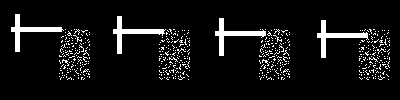

In [127]:
unroll(img)

## Task 1: Hassenstein-Reichardt Detector

### Preprocessing by on-cells

- on-cells calculate a **temporal difference**
- no spatial offset

In [128]:
function on_cells(imgs)    
    diff_imgs = diff(imgs, dims=1)
    diff_imgs = max.(diff_imgs, 0)
    return diff_imgs
end

on_cells (generic function with 1 method)

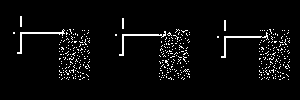

In [129]:
on = on_cells(img)
on_unrolled = unroll(on)

### Half-detectors

- half-detectors take input from on-cells
- perform a spatial shift $(\Delta x, \Delta y)$
- compare non-delayed and delayed signal

In [130]:
function half_detectors(ons, Δx, Δy, Δt)
    # shift arrays relative to each other
    # ...to be implemented:
    frames, rows, cols = size(ons)

    hd1 = zeros(frames - Δt, rows, cols)
    hd2 = zeros(frames - Δt, rows, cols)
    
    padding_vertical = (max(Δy, 0), max(Δy, 0))
    padding_horizontal = (max(Δx, 0), max(Δx, 0))
    border = Pad(:symmetric, padding_vertical[1], padding_horizontal[1])

    padded_ons = [padarray(ons[t, :, :], border) for t in 1:frames] 
    # get multiplies with both temporal offsets
    # ...to be implemented:
    for t in 1:(frames - Δt)
        current_frame = padded_ons[t][1:rows, 1:cols]
        future_frame = padded_ons[t + Δt][1:rows, 1:cols]
        hd1[t, :, :] = ons[t, :, :] .* future_frame  
        hd2[t, :, :] = ons[t + Δt, :, :] .* current_frame 
    end

    return hd1, hd2
end




half_detectors (generic function with 1 method)

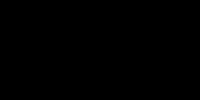

In [131]:
hd1, hd2 = half_detectors(on, 1, 1, 1)
unroll(hd1)

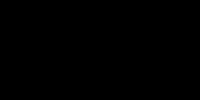

In [132]:
unroll(hd2)

### Full detectors

- full detectors take difference of two half-detectors (same spatial offset, opposite direction)

In [133]:
function full_detectors(hd1s, hd2s)
    # ...to be implemented:
    return hd1s - hd2s
end

full_detectors (generic function with 1 method)

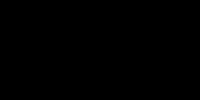

In [134]:
fd = full_detectors(hd1, hd2)
unroll(fd)

### Putting it all together

In [135]:
function hrd(imgs, Δx, Δy, Δt)
    # ...to be implemented:
    ons = on_cells(imgs)
    hd1, hd2 = half_detectors(ons, Δx, Δy, Δt)
    return full_detectors(hd1, hd2)     
end

hrd (generic function with 1 method)

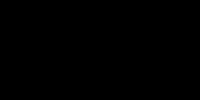

In [136]:
unroll(hrd(img, 1, 1, 1))

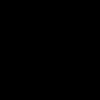

In [137]:
unroll(hrd(img, 0, 3, 2))

## Task 2: Motion Integration

- Try motion **hypotheses** (each offset in a certain range) and score their quality
- **Aggregate** quality over a local neighborhood
- Find **best** fitting direction at each location

### Help with plotting

- Again, start with a utility function (plot all motion hypotheses on 2D grid)

In [138]:
function stack4D(imgs)
    Gray.(hcat([vcat([imgs[i, j, :, :] for i in 1:size(imgs,1)]...) for j in 1:size(imgs, 2)]...))
end

stack4D (generic function with 1 method)

### Shift and compare

- Implement relative **shift** by padding
- **Compare** via square difference (lower = better)

In [139]:
# function paddedcomp(img1, img2, Δx, Δy; compfun = (x, y) -> (x - y)^2)
#      # Calculate padding
#     pad_top = max(Δy, 0)
#     pad_bottom = max(-Δy, 0)
#     pad_left = max(Δx, 0)
#     pad_right = max(-Δx, 0)

#     # Apply symmetric padding
#     padded = padarray(img2, Pad(:symmetric, (pad_top, pad_bottom), (pad_left, pad_right)))

#     # Circshift, then select the central part that matches the original dimensions of img1
#     shifted = circshift(padded, (Δy, Δx))
#     central_part = shifted[pad_top + 1:end - pad_bottom, pad_left + 1:end - pad_right]

#     # Ensure the central part has the same dimensions as img1
#     if size(central_part) != size(img1)
#         error("Dimension mismatch: Expected $(size(img1)), got $(size(central_part))")
#     end

#     # Compute the squared difference
#     return compfun.(img1, central_part)
#     # Calculate padding.
#     # ...to be implemented: 
#     # Apply padding
#     # ...to be implemented: 
#     # compare element-wise
#     # ...to be implemented: 
#     # Select original image region from result.
#     # We assume our result is anchored to img1
#     # ...to be implemented: 
# end

In [157]:

function paddedcomp(img1, img2, Δx, Δy; compfun = (x, y) -> (x - y)^2)
    # Calculate padding, ensure to cover the full shift range
    pad_top = max(Δy, 0)
    pad_bottom = max(-Δy, 0)
    pad_left = max(Δx, 0)
    pad_right = max(-Δx, 0)

    println(size(img2))

    # Symmetric padding to handle boundaries
    padded = padarray(img2, Pad(:symmetric, (pad_top, pad_bottom), (pad_left, pad_right)))
    println(size(padded))
    # Shift the padded image
    shifted = circshift(padded, (Δy, Δx))
    println(size(shifted))
    println(size(img1))

    # Compute the squared difference
    return compfun.(img1, shifted)
end


paddedcomp (generic function with 1 method)

- Perform comparison for every shift in a given range

In [158]:
function shiftcompare(img1, img2, Δxs, Δys)
    @assert size(img1) == size(img2) "img1 and img2 must be of same size"
    # ...to be implemented:
     # Initialize a container to hold the comparison results for each shift
     results = Dict()

     # Iterate over all specified Δx and Δy shifts
     for Δy in Δys
         for Δx in Δxs
             # Use paddedcomp to perform the shift and comparison
             comparison_result = paddedcomp(img1, img2, Δx, Δy)
 
             # Store the result in a dictionary with the shift as the key
             results[(Δx, Δy)] = comparison_result
         end
     end
 
     return results 
end

shiftcompare (generic function with 1 method)

In [159]:
comp = shiftcompare(img[1,:,:], img[2,:,:], -3:3, -3:3)
stack4D(comp)

(100, 100)
(100, 106)
(100, 106)
(100, 100)


DimensionMismatch: DimensionMismatch: arrays could not be broadcast to a common size; got a dimension with lengths 100 and 106

### Local sum

In [148]:
function localavg(comps; ksize=(5,5))
    # Create a kernel for averaging (uniform filter)
    kernel = ones(ksize...) / prod(ksize)

    # Apply the kernel to each comparison result
    # Assuming comps is a dictionary with keys as (Δx, Δy) and values as matrices of squared differences
    averaged_comps = Dict()
    for (shift, comp) in comps
        # Convolve the comparison matrix with the averaging kernel
        averaged_comps[shift] = imfilter(comp, kernel, "replicate")  # Using "replicate" to handle borders
    end
    return averaged_comps# ...to be implemented: 
end

localavg (generic function with 1 method)

In [149]:
avg = localavg(comp);
stack4D(avg)

MethodError: MethodError: no method matching iterate(::Nothing)

Closest candidates are:
  iterate(!Matched::Base.MethodSpecializations)
   @ Base reflection.jl:1148
  iterate(!Matched::Base.MethodSpecializations, !Matched::Nothing)
   @ Base reflection.jl:1154
  iterate(!Matched::Base.MethodSpecializations, !Matched::Int64)
   @ Base reflection.jl:1155
  ...


### Finding motion directions

- Find **best** (minimum difference) direction in each location
- Check whether optimum is unique

In [145]:
function uniqueminima(motions, Δxs, Δys)
    # ...to be implemented: 
    return(xs, ys, Δxₘₐₓ, Δyₘₐₓ)
end

uniqueminima (generic function with 1 method)

### Displaying the results

- Our `uniqueminima` function returns the results in the correct format for a quiver plot

In [146]:
xs, ys, Δx, Δy = uniqueminima(avg, -3:3, -3:3);

UndefVarError: UndefVarError: `xs` not defined

In [147]:
quiver(ys, 100 .- xs, quiver=(Δy, -Δx))

UndefVarError: UndefVarError: `xs` not defined